In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yfin
import math
import matplotlib_inline.backend_inline 
import statsmodels.api as sm
from patsy import dmatrices
import random

matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')

plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

In [55]:
# 1.1 SPY vs AAPL CAPM Model 

data = yfin.download(tickers=['SPY', 'AAPL'], start='2010-01-01', end='2022-01-01', interval='1d')
data = data['Adj Close'].pct_change().fillna(method='bfill')

y, X = dmatrices(f"AAPL ~ SPY", data=data, return_type="dataframe")

model = sm.OLS(y, X) 
results = model.fit()

results.params

[*********************100%***********************]  2 of 2 completed


Intercept    0.000584
SPY          1.093151
dtype: float64

Assuming the risk free rate is zero, the CAPM model between SPY and AAPL can be fitted using $r_{aapl} = \alpha + \beta r_{spy}$. Plugging in our $\alpha$ and $\beta$ values from above, we get the regression line $r_{aapl} = 0.000584 + 1.093151 r_{spy}$.

<function matplotlib.pyplot.show(close=None, block=None)>

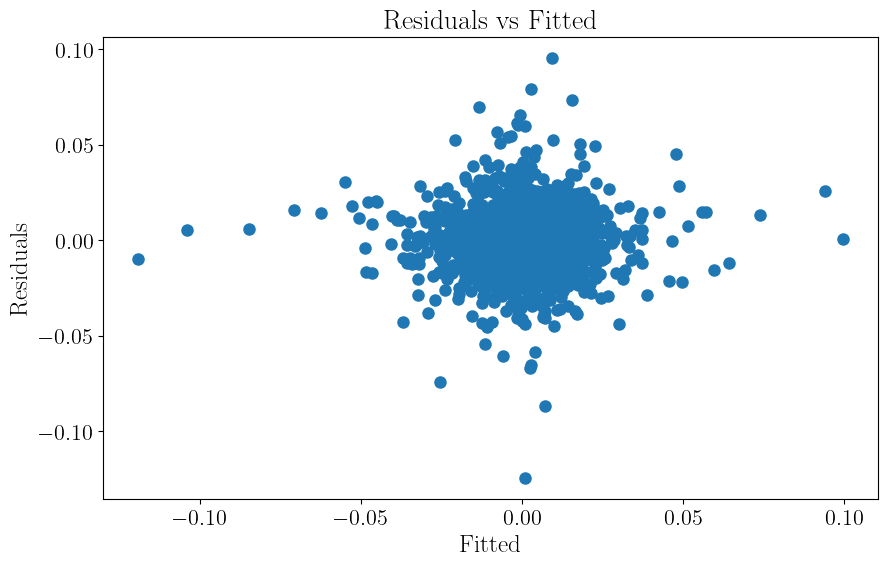

In [56]:
# 1.2 Residuals vs. Fitted

fittedValues = results.fittedvalues
residuals = y['AAPL'] - fittedValues

plt.scatter(fittedValues, residuals)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.show

In [57]:
# 1.2 Residual Sum of Squares RSS

RSS = sum(np.square(residuals))

RSS

0.5316488696383749

In [58]:
# 1.3 Null Regression Model

X = np.ones(len(y), dtype = int)

null_model = sm.OLS(y, X) 
null_results = null_model.fit()

null_results.params

const    0.00125
dtype: float64

In [59]:
# 1.3 Alpha in Null Regression Model

np.mean(y)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


AAPL    0.00125
dtype: float64

As we can see above, the estimated coefficient $\alpha$ in the regression output is equal to the mean of AAPL returns. 

In [60]:
# 1.4 R Squared Using Formula

null_fittedValues = null_results.fittedvalues

null_residuals = y['AAPL'] - null_fittedValues

null_RSS = sum(np.square(null_residuals))

r_squared = 1 - (RSS/null_RSS)

r_squared


0.4358922873119354

In [61]:
# 1.4 R Squared 

results.rsquared

0.4358922873119355

1.5 

In order for $R^2$ to be between 0 and 1, $\frac{RSS_M}{RSS_0}$ must also be between 0 and 1. We know this is true since 
1. both $RSS_M$ and $RSS_0$ are nonnegative as they are the sum of squares and
2. $RSS_M \le RSS_0$ as the CAPM model for $RSS_M$ minimizes residuals whereas the null regression model for $RSS_0$ simply finds residuals by subtracting observed values by their mean.

![2 Martingales](2.jpeg)

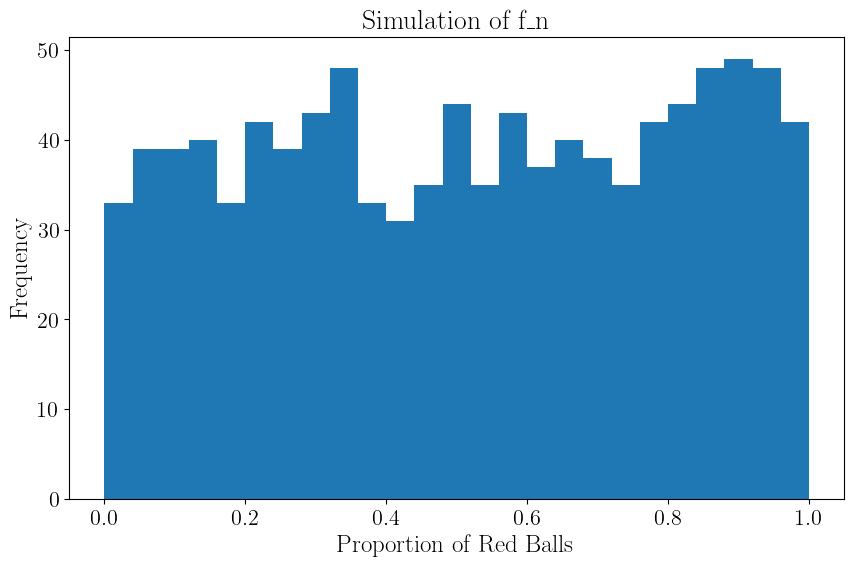

In [62]:
# 2.3 Simulate Distribution of f_n

def frac_of_red(n):
    red = 1
    green = 1
    for trial in range(n):
        pick = np.random.choice(['red', 'green'], p = [red/(red + green), green/(red + green)])
        if pick == 'red':
            red += 1
        else: 
            green += 1
    return (red/(red + green))

proportion_red = [frac_of_red(10000) for trial in range(1000)]

plt.hist(proportion_red, bins=25)
plt.title('Simulation of f_n')
plt.xlabel('Proportion of Red Balls')
plt.ylabel('Frequency')
plt.show()

My guess for the distribution of $f_n$ is uniform as we can see in the histogram above that every proportion of red balls has about the same probability as n heads towards infinity.

![2.4](2_4.jpeg)

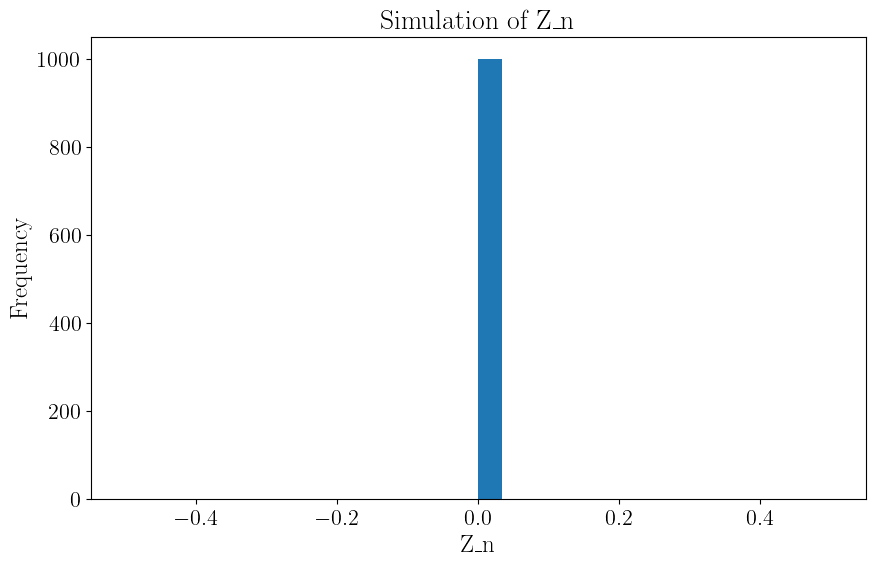

In [63]:
# 2.4 (d) Simulate Z_n

def simulations():
    z_previous = 1
    for i in range(10000):
        z = 0
        for j in range(z_previous):
            epsilon = np.random.poisson(1)
            z += epsilon
        z_previous = z
    return z_previous

Z = [simulations() for trial in range(1000)]

plt.hist(Z, bins=30)
plt.title('Simulation of Z_n')
plt.xlabel('Z_n')
plt.ylabel('Frequency')
plt.show()

When n goes to infinity, we can see that $Z_n$ goes to 0. This makes sense because $Z_n$ is the summation of poissons which is poisson. 

![2.5](2_5.jpeg)

![3 Doob](3.jpeg)

In [3]:
# 3.3 Game Simulation
probabilities = [0.5, 0.495, 0.490, 0.480, 0.470]

def random_walk(p):
    prob = [p, 1 - p] 
    money = 0
    duration = 0
    while money > -100 and money < 100:
        x = np.random.random(1)
        if x < prob[0]:
            money += 1
        else:
            money -= 1
        duration += 1
    return money, duration

def simulation(p, trials):
    num_wins = 0
    sum_duration = 0
    for trial in range(trials):
        if random_walk(p)[0] == 100:
            num_wins += 1
        sum_duration += random_walk(p)[1]
    prob_win = num_wins/trials
    ave_duration = sum_duration/trials
    return (prob_win, ave_duration) 

stats = [simulation(p, 10000) for p in probabilities]

stats

KeyboardInterrupt: 

![3.3](3_3.jpeg)

3.4 

I would bet $100 on the first bet. As we can see in the table above by continously betting $1 until we win $100, the probability of winning $100 before losing $100 decreases exponentially for marginal decreases in probabilty $p$. Further, the probability of winning $100 by betting $1 is lower in all 5 cases than just winning in one trial. In other words, $p$ > P(winning $100 before losing $100) for all values of $p$.

In [53]:
# 3.5 Stopping Time Simulation

def stopping_time(p):
    prob = [p, 1 - p] 

    money_won = 0
    duration = 0

    while money_won < 1:
        x = np.random.random(1)
        if x < prob[0]:
            money_won += 1
        duration += 1

    return duration

durations = [stopping_time(0.5) for trial in range(1000)]

np.mean(durations)



1.981

$\tau$ is a stopping time since it is a fixed time value where it is possible to determine if it has been reached at any realization. The computed estimate for the expectation of $\tau$ is 1.981.